In [6]:
import os
import random
import numpy as np
import tensorflow as tf
from tqdm import tqdm

import torch
from torch import nn, optim
from sklearn.datasets import load_iris, load_digits

%matplotlib inline
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize']=(10,5)
import seaborn as sns; sns.set()

In [2]:
## シード固定
def fix_seed(seed=42):  # https://www.kaggle.com/kaerunantoka/titanic-pytorch-nn-tutorial
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


## 単純な線形モデル
def torch_simple_nn(X, y, lr, loss_fn, output_features=1, epochs=20, ):
    net = nn.Linear(in_features = X.size()[1], out_features = output_features, bias = False)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    loss_fn = loss_fn

    losses = []
    for epoc in tqdm(range(epochs)):
        optimizer.zero_grad()  # 勾配の値を初期化
        y_pred = net(X)  # 予測値を計算
        if output_features==1:
            loss = loss_fn(y_pred.view_as(y), y)  # lossを計算、view_asでshapeを変換
        else:
            loss = loss_fn(y_pred, y)
        loss.backward()  # loss の w による微分を計算
        optimizer.step()  # 勾配を更新する
        losses.append(loss.item())  # 収束確認のために loss を記録しておく
        
    return net, losses


## 予測
def torch_predict(net, X, y, model_type):
    h = net(X)  # 線形結合の結果
    if model_type=="binary":
        prob = torch.sigmoid(h)  # シグモイド関数を作用させた結果は y=1 の確率を表す
        y_pred = prob > 0.5  # 確率が0.5以上のものをクラス1と予想し、それ以外を0とする
        accuracy_score = (y.byte() == y_pred.view_as(y)).sum().item() / len(y)  # PyTorch には Bool型がないので対応する型として ByteTensor が出力される
    elif model_type=="multi_class":
        prob, y_pred = torch.max(h, 1)
        accuracy_score = (y_pred==y).sum().item() / len(y)
    else:
        assert model_type=="binary" or model_type=="multi_class", "model_type must be binary or multi-class"
        
    return prob, y_pred, accuracy_score


## ロスの減少の様子をグラフ化する
def plot_losses(losses):
    plt.plot(losses)
    plt.show()

In [3]:
fix_seed()

## 単純な線形回帰モデル

In [4]:
# 真の係数
w_true = torch.Tensor([1,2,3])
print("真の係数: ", w_true)

# Xとyを定義
X = torch.cat([torch.ones(100,1), torch.randn(100,2)], 1)
y = torch.mv(X, w_true) + torch.randn(100) * 0.5

真の係数:  tensor([1., 2., 3.])


100%|██████████| 100/100 [00:00<00:00, 4579.13it/s]


[Parameter containing:
tensor([[1.1046, 2.0486, 2.9930]], requires_grad=True)]


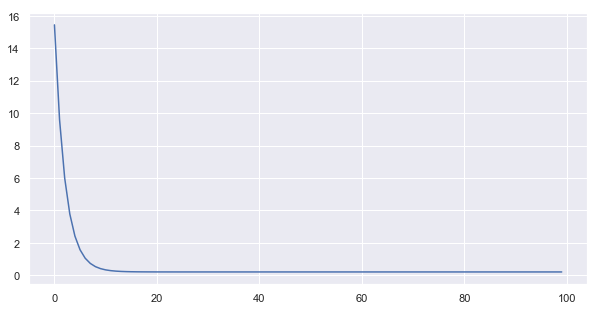

In [7]:
# モデル構築
net, losses = torch_simple_nn(X, y, lr=0.1, loss_fn=nn.MSELoss(), epochs=100)
print( list(net.parameters()) )
plot_losses(losses)

## 単純なロジスティック回帰

In [8]:
iris = load_iris()
X = iris.data[:100]
y = iris.target[:100]

# Numpy の ndarray を PyTorch の Tensor に変換
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

100%|██████████| 100/100 [00:00<00:00, 1873.32it/s]


[Parameter containing:
tensor([[-0.4699, -1.4188,  2.2596,  0.8685]], requires_grad=True)]


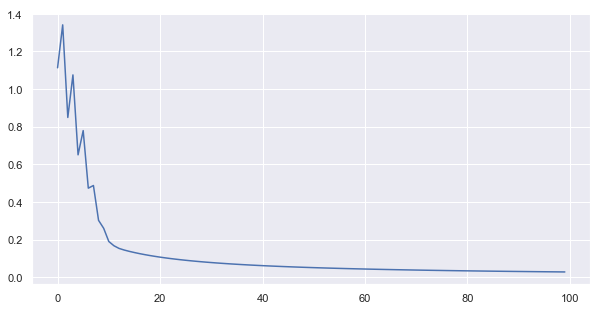

In [9]:
# モデル構築
net, losses = torch_simple_nn(X, y, lr=0.25, loss_fn=nn.BCEWithLogitsLoss(), epochs=100)
print( list(net.parameters()) )
plot_losses(losses)

In [10]:
# モデルで予測
prob, y_pred, accuracy_score = torch_predict(net, X, y, model_type="binary")
print("正解率: ", accuracy_score)

正解率:  1.0


## 多クラス分類

In [11]:
digits = load_digits()
X = digits.data
y = digits.target

# Numpy の ndarray を PyTorch の Tensor に変換
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)  # CrossEntropyLoss 関数は y として int64型の Tensor を受け取るので注意

100%|██████████| 100/100 [00:00<00:00, 825.95it/s]


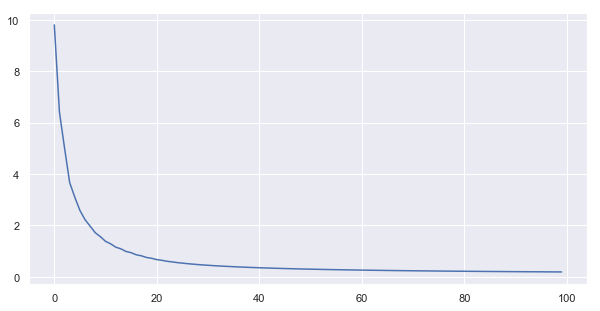

In [12]:
# モデル構築
net, losses = torch_simple_nn(X, y, lr=0.01, loss_fn=nn.CrossEntropyLoss(), output_features=10, epochs=100)
plot_losses(losses)

In [13]:
# モデルで予測
prob, y_pred, accuracy_score = torch_predict(net, X, y, model_type="multi_class")
print("正解率: ", accuracy_score)

正解率:  0.9543683917640512
